# Linear mixed effect models (Phylotypes)

In [1]:
MIN_PREV = 0.1
MIN_RA = 1e-4

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import quantile_transform
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# import anndata as ad

In [3]:
# Color 
my_palette = ["grey", "#CBC3E3"]

In [4]:
sv_tax = pd.read_csv(
    '../training_data/training_data_2022-08-25/taxonomy/sv_taxonomy.csv'
)
sv_tax.head()

,sv,want_rank,tax_id,tax_name,rank,likelihood
0,combinedsv___25372,root,1,root,root,1.0
1,combinedsv___25372,phylum,1239,Firmicutes,phylum,1.0
2,combinedsv___25372,phylum_,1239,Firmicutes,phylum,1.0
3,combinedsv___25372,subphylum,1239,Firmicutes,phylum,1.0
4,combinedsv___25372,family,1300,Streptococcaceae,family,1.0


In [6]:
pt_sv = pd.read_csv(
    '../training_data/training_data_2022-08-25/phylotypes/pt.1e-1.csv'
)
pt_sv

,phylotype,sv
0,pt__00001,combinedsv___36905
1,pt__00001,combinedsv___32709
2,pt__00001,combinedsv___4093
3,pt__00001,combinedsv___47319
4,pt__00001,combinedsv___41664
...,...,...
53124,pt__09713,combinedsv___43701
53125,pt__09714,combinedsv___44644
53126,pt__09715,combinedsv___33715
53127,pt__09716,combinedsv___32867


We create a table with phylotypes and taxonomy information for being able to indentify the different species of bacteria.

In [7]:
pt_tax_l = pd.merge(
    pt_sv,
    sv_tax[
        (sv_tax.want_rank == 'species') &
        (sv_tax['rank'] == 'species')
    ],
    on='sv',
    how='left'
)
pt_tax_l

,phylotype,sv,want_rank,tax_id,tax_name,rank,likelihood
0,pt__00001,combinedsv___36905,species,147802,Lactobacillus iners,species,1.000000
1,pt__00001,combinedsv___32709,species,147802,Lactobacillus iners,species,0.381212
2,pt__00001,combinedsv___4093,species,147802,Lactobacillus iners,species,1.000000
3,pt__00001,combinedsv___47319,species,147802,Lactobacillus iners,species,1.000000
4,pt__00001,combinedsv___41664,species,147802,Lactobacillus iners,species,1.000000
...,...,...,...,...,...,...,...
53124,pt__09713,combinedsv___43701,NaN,NaN,NaN,NaN,NaN
53125,pt__09714,combinedsv___44644,species,267135,Porphyrobacter donghaensis,species,0.738235
53126,pt__09715,combinedsv___33715,NaN,NaN,NaN,NaN,NaN
53127,pt__09716,combinedsv___32867,NaN,NaN,NaN,NaN,NaN


For those samples wihout a specific specie, we add the genus, family o whatever has been identified.

In [8]:
pt_tax = pt_tax_l[
    ~pt_tax_l.tax_name.isna()
].groupby(['phylotype', 'tax_name']).count().reset_index().sort_values(
    'sv', ascending=False
).groupby('phylotype').first()[['tax_name']]
pt_tax

,tax_name
phylotype,
pt__00001,Lactobacillus iners
pt__00002,Gardnerella vaginalis
pt__00004,Lactobacillus jensenii
pt__00005,Lactobacillus gasseri
pt__00006,Pseudomonas fluorescens/veronii
...,...
pt__09709,Holdemania massiliensis
pt__09710,Cutibacterium granulosum
pt__09712,Pararheinheimera tangshanensis


In [9]:
pt_no_sp = set(pt_sv.phylotype) - set(pt_tax.index)
pt_tax = pd.concat(
    [
        pt_tax,
        pd.merge(
            pt_sv[
                pt_sv.phylotype.apply(lambda pt: pt in pt_no_sp)
            ],
            sv_tax[
                (sv_tax.want_rank == 'species') 
            ],
            on='sv',
            how='left'
        ).groupby(['phylotype', 'tax_name']).count().reset_index().sort_values(
            'sv', ascending=False
        ).groupby('phylotype').first()[['tax_name']]        
    ]
)
pt_tax 

,tax_name
phylotype,
pt__00001,Lactobacillus iners
pt__00002,Gardnerella vaginalis
pt__00004,Lactobacillus jensenii
pt__00005,Lactobacillus gasseri
pt__00006,Pseudomonas fluorescens/veronii
...,...
pt__09708,Erysipelotrichaceae/Ruminococcaceae
pt__09711,Alishewanella
pt__09713,Pinisolibacter


In [10]:
ptw = pd.read_csv(
    '../training_data/training_data_2022-08-25/phylotypes/phylotype_relabd.1e_1.csv',
    index_col=0
).T
ptw.head()

specimen,A00001-05,A00002-01,A00003-02,A00004-08,A00004-12,A00004-13,A00004-16,A00004-18,A00004-20,A00004-22,...,J00105-01,J00106-01,J00107-01,J00108-01,J00109-01,J00111-01,J00112-01,J00113-01,J00115-01,J00116-01
pt__00001,0.593176,0.001226,0.000000,0.927544,0.806593,0.686465,0.936201,0.854209,0.940401,0.934459,...,0.0,0.0,0.001780,0.000000,0.000000,0.994886,0.014129,0.476964,0.949578,0.003957
pt__00002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pt__00003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pt__00004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.002069,0.153151,0.000077,0.000000,0.141649,0.001736,0.000439,0.004445
pt__00005,0.121260,0.000613,0.002591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.324239,0.932975,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
md = pd.read_csv(
    '../training_data/training_data_2022-08-25/metadata/metadata_normalized.csv'
)
md['trimester'] = [1 if x <= 13 else 2 if x <=26 else 3 for x in md.collect_wk]
md = md.query('collect_wk >= 6 and collect_wk <=36')
md

,project,specimen,participant_id,collect_wk,age,Race: American Indian or Alaska Native,Race: Asian,Race: Black or African American,Race: Native Hawaiian or Other Pacific Islander,Race: Unknown,Race: White,Ethnicity: Hispanic or Latino,Ethnicity: Unknown,trimester
0,A,A00001-05,A00001,33.0,Unknown,1,0,0,0,0,0,0,1,3
2,A,A00003-02,A00003,30.0,Unknown,0,1,0,0,0,0,0,1,3
3,A,A00004-08,A00004,27.0,Unknown,0,0,0,0,0,1,0,1,3
4,A,A00004-12,A00004,29.0,Unknown,0,0,0,0,0,1,0,1,3
5,A,A00004-13,A00004,30.0,Unknown,0,0,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,J,J00111-01,J00111,17.0,27,0,0,0,0,0,1,0,1,2
3574,J,J00112-01,J00112,19.0,27,0,0,0,0,0,1,0,1,2
3575,J,J00113-01,J00113,16.0,32,0,0,0,0,0,1,0,1,2
3576,J,J00115-01,J00115,18.0,35,0,0,0,0,0,1,0,1,2


In [12]:
ptw = ptw.loc[:,md.specimen] 
ptw # To make sure we have the same samples and both datasets.

specimen,A00001-05,A00003-02,A00004-08,A00004-12,A00004-13,A00004-16,A00004-18,A00005-02,A00005-05,A00005-10,...,J00105-01,J00106-01,J00107-01,J00108-01,J00109-01,J00111-01,J00112-01,J00113-01,J00115-01,J00116-01
pt__00001,0.593176,0.000000,0.927544,0.806593,0.686465,0.936201,0.854209,0.000476,0.000000,0.000000,...,0.0,0.0,0.001780,0.000000,0.000000,0.994886,0.014129,0.476964,0.949578,0.003957
pt__00002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pt__00003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pt__00004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.002069,0.153151,0.000077,0.000000,0.141649,0.001736,0.000439,0.004445
pt__00005,0.121260,0.002591,0.000000,0.000000,0.000000,0.000000,0.000000,0.752857,0.912218,0.880232,...,0.0,0.0,0.000000,0.324239,0.932975,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pt__09713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pt__09714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pt__09715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pt__09716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
[
    c for c in 
    md.columns
    if c.startswith('Race:')
]

['Race: American Indian or Alaska Native',
 'Race: Asian',
 'Race: Black or African American',
 'Race: Native Hawaiian or Other Pacific Islander',
 'Race: Unknown',
 'Race: White']

In [14]:
specimen_project = {
    sp: p
    for (sp, p) in
    zip(
        md.specimen,
        md.project
    )
    
}

In [15]:
specimen_participant = {
    sp: p
    for (sp, p) in
    zip(
        md.specimen,
        md.participant_id
    )
    
}

In [16]:
key = pd.read_csv(
    '../training_data/training_data_2022-08-25/key/answer_key.csv',
    index_col=0
)
key.head()

,participant_id,delivery_wk,was_preterm,was_early_preterm
specimen,,,,
A00001-05,A00001,38.0,0,0
A00002-01,A00002,40.0,0,0
A00003-02,A00003,40.0,0,0
A00004-08,A00004,40.0,0,0
A00004-12,A00004,40.0,0,0


We create the 'endog' which would be the dependet variable.

In [17]:
preterm_endog = key.loc[
    [c for c in ptw.columns if c in key.index]
].was_preterm
preterm_endog

specimen
A00001-05    0
A00003-02    0
A00004-08    0
A00004-12    0
A00004-13    0
            ..
J00111-01    0
J00112-01    0
J00113-01    0
J00115-01    0
J00116-01    0
Name: was_preterm, Length: 3456, dtype: int64

In [18]:
ept_endog = key.loc[
    [c for c in ptw.columns if c in key.index]
].was_early_preterm
ept_endog

specimen
A00001-05    0
A00003-02    0
A00004-08    0
A00004-12    0
A00004-13    0
            ..
J00111-01    0
J00112-01    0
J00113-01    0
J00115-01    0
J00116-01    0
Name: was_early_preterm, Length: 3456, dtype: int64

Now, we create the random effects for the project.

In [19]:
group = pd.Series(
    [
        specimen_project.get(s)
        for s in ptw.columns
    ],
    index=ptw.columns
)
group

specimen
A00001-05    A
A00003-02    A
A00004-08    A
A00004-12    A
A00004-13    A
            ..
J00111-01    J
J00112-01    J
J00113-01    J
J00115-01    J
J00116-01    J
Length: 3456, dtype: object

We create the LMM for preterm and early preterm and for each phyotype which exceed the thresholds.

## Preterm model

In [20]:
pt_models_ra_ptb_wmd = {}
for pt, pt_data in ptw.iterrows():
    if (pt_data > MIN_RA).sum() / len(pt_data) < MIN_PREV:
        continue
    # Implicit else prevalent enough phylotype...
    exog = sm.add_constant(
        pt_data.to_frame(pt)
    )
    exog_wmd = pd.merge(
        exog,
        md[[
            'specimen',
            'Race: American Indian or Alaska Native',
            'Race: Asian',
            'Race: Black or African American',
            'Race: Native Hawaiian or Other Pacific Islander',
            'Race: Unknown',
            'Race: White',
            'trimester'
        ]],
        left_index=True,
        right_on='specimen',
        how='left'
    )
    exog_wmd.drop('specimen', inplace=True, axis=1)
    exog_wmd.index = exog.index
    m = sm.MixedLM(
        exog=exog_wmd,
        endog=preterm_endog,
        groups=group
    ).fit()

    # Implict else did not error

    pt_models_ra_ptb_wmd[pt] = m

In [25]:
pt_models_ra_ptb_wmd['pt__00021'].predict() # test

array([1.03047698, 0.27296169, 0.29638811, ..., 0.39062402, 0.38487512,
       0.33546664])

In [21]:
pt_res_ra_ptb = pd.DataFrame([
    {
        'phylotype': pt,
        'coef': pt_m.params[pt],
        'bse': pt_m.bse[pt],
        'p': pt_m.pvalues[pt]
    }
    for pt, pt_m in pt_models_ra_ptb_wmd.items()
])
pt_res_ra_ptb['wald'] = pt_res_ra_ptb['coef'] / pt_res_ra_ptb['bse']
pt_res_ra_ptb['q'] = multipletests(
    pt_res_ra_ptb['p'],
    method='fdr_bh'
)[1]
pt_res_ra_ptb

,phylotype,coef,bse,p,wald,q
0,pt__00001,0.008181,0.021719,0.706415,0.376675,0.886297
1,pt__00002,0.005296,0.067301,0.937278,0.078692,0.975462
2,pt__00003,0.083038,0.130682,0.525154,0.635421,0.768281
3,pt__00004,-0.096103,0.042571,0.023978,-2.257483,0.157855
4,pt__00005,-0.145120,0.044919,0.001235,-3.230697,0.024389
...,...,...,...,...,...,...
74,pt__00117,-5.363042,1.876313,0.004259,-2.858288,0.056081
75,pt__00143,-3.644911,2.690966,0.175577,-1.354499,0.407967
76,pt__00225,-3.015567,1.564234,0.053877,-1.927823,0.283753
77,pt__00358,-0.156923,0.218309,0.472256,-0.718813,0.717466


In [22]:
pt_res_ra_ptb[
    pt_res_ra_ptb.q <= 0.1
].sort_values('wald')

,phylotype,coef,bse,p,wald,q
20,pt__00021,-0.130080,0.031706,0.000041,-4.102698,0.003226
4,pt__00005,-0.145120,0.044919,0.001235,-3.230697,0.024389
74,pt__00117,-5.363042,1.876313,0.004259,-2.858288,0.056081
55,pt__00061,-3.423437,1.224386,0.005173,-2.796043,0.058384
34,pt__00036,0.651831,0.243542,0.007441,2.676457,0.073475
26,pt__00028,3.355178,1.130004,0.002986,2.969172,0.047179
44,pt__00048,4.451710,1.303002,0.000634,3.416503,0.016703
11,pt__00012,0.694965,0.197245,0.000426,3.523359,0.016703


In [23]:
results_ptb = pd.merge(
    pt_res_ra_ptb[
        pt_res_ra_ptb.q <= 0.1
    ].sort_values('wald'),
    pt_tax,
    left_on='phylotype',
    right_index=True,
    how='left'
)
results_ptb.to_csv('outputs/results_ptb_lmm.csv')
results_ptb

,phylotype,coef,bse,p,wald,q,tax_name
20,pt__00021,-0.130080,0.031706,0.000041,-4.102698,0.003226,Lactobacillus crispatus
4,pt__00005,-0.145120,0.044919,0.001235,-3.230697,0.024389,Lactobacillus gasseri
74,pt__00117,-5.363042,1.876313,0.004259,-2.858288,0.056081,Corynebacterium jeikeium
55,pt__00061,-3.423437,1.224386,0.005173,-2.796043,0.058384,Corynebacterium coyleae
34,pt__00036,0.651831,0.243542,0.007441,2.676457,0.073475,Sneathia sanguinegens
26,pt__00028,3.355178,1.130004,0.002986,2.969172,0.047179,Parvimonas micra
44,pt__00048,4.451710,1.303002,0.000634,3.416503,0.016703,Mobiluncus curtisii
11,pt__00012,0.694965,0.197245,0.000426,3.523359,0.016703,Prevotella buccalis


### Plot results

In [24]:
metadata = pd.read_csv('../training_data/training_data_2022-08-25/metadata/metadata.csv',sep=',')
metadata = metadata.set_index('specimen',drop=True)
metadata['Type'] = ['Term' if i > 36 else 'Preterm' for i in metadata.delivery_wk]
metadata['trimester'] =  pd.cut(metadata.collect_wk,[0,13,26,42],labels=[1,2,3])
display(metadata)

,project,participant_id,was_term,delivery_wk,collect_wk,race,age,NIH Racial Category,NIH Ethnicity Category,was_preterm,was_early_preterm,Type,trimester
specimen,,,,,,,,,,,,,
A00001-05,A,A00001,False,38.0,33.0,American Indian,Unknown,American Indian or Alaska Native,Unknown,False,False,Term,3
A00002-01,A,A00002,False,40.0,38.0,White,Unknown,White,Unknown,False,False,Term,3
A00003-02,A,A00003,False,40.0,30.0,Asian-Japanese,Unknown,Asian,Unknown,False,False,Term,3
A00004-08,A,A00004,False,40.0,27.0,White,Unknown,White,Unknown,False,False,Term,3
A00004-12,A,A00004,False,40.0,29.0,White,Unknown,White,Unknown,False,False,Term,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
J00111-01,J,J00111,False,40.0,17.0,Caucasian,27,White,Unknown,False,False,Term,2
J00112-01,J,J00112,False,39.0,19.0,Caucasian,27,White,Unknown,False,False,Term,2
J00113-01,J,J00113,False,41.0,16.0,Caucasian,32,White,Unknown,False,False,Term,2


In [25]:
ptw_plot1 = pd.melt(ptw.loc[results_ptb['phylotype'],:].T.reset_index(),
                    id_vars='specimen',var_name='Phylotype',value_name='score')
ptw_plot1

,specimen,Phylotype,score
0,A00001-05,pt__00021,0.0
1,A00003-02,pt__00021,0.0
2,A00004-08,pt__00021,0.0
3,A00004-12,pt__00021,0.0
4,A00004-13,pt__00021,0.0
...,...,...,...
27643,J00111-01,pt__00012,0.0
27644,J00112-01,pt__00012,0.0
27645,J00113-01,pt__00012,0.0
27646,J00115-01,pt__00012,0.0


In [73]:
ptw_plot = pd.merge(ptw_plot1,metadata,on='specimen',how = 'left')
ptw_plot = ptw_plot.query('score > 0.5') # 0.1
ptw_plot

,specimen,Phylotype,score,project,participant_id,was_term,delivery_wk,collect_wk,race,age,NIH Racial Category,NIH Ethnicity Category,was_preterm,was_early_preterm,Type,trimester
208,B00001-01,pt__00021,0.987768,B,B00001,False,38.0,17.0,Caucasian,37,White,Unknown,False,False,Term,2
211,B00005-01,pt__00021,0.999089,B,B00005,False,40.0,17.0,Caucasian,35,White,Unknown,False,False,Term,2
212,B00006-01,pt__00021,0.978590,B,B00006,False,39.0,17.0,Caucasian,39,White,Unknown,False,False,Term,2
214,B00008-01,pt__00021,0.966874,B,B00008,True,36.0,17.0,Caucasian,36,White,Unknown,True,False,Preterm,2
215,B00009-01,pt__00021,1.000000,B,B00009,False,39.0,18.0,Caucasian,34,White,Unknown,False,False,Term,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14114,C00036-02,pt__00036,0.544832,C,C00036,True,30.0,29.0,Black,26,Black or African American,Unknown,True,True,Preterm,3
14198,C00109-01,pt__00036,0.563000,C,C00109,True,25.0,25.0,Black,34,Black or African American,Unknown,True,True,Preterm,2
25305,G00040-01,pt__00012,0.566852,G,G00040,True,17.0,15.0,Black,31.0,Black or African American,Unknown,True,True,Preterm,2
25988,H00108-02,pt__00012,0.680830,H,H00108,True,34.0,11.0,african_american,18_to_28,Black or African American,Unknown,True,False,Preterm,1


In [27]:
ptw_plot.groupby(['Phylotype','trimester']).count()

specimen  score  project  participant_id  was_term  \
Phylotype trimester                                                       
pt__00005 1                15     15       15              15        15   
          2               172    172      172             172       172   
          3                30     30       30              30        30   
pt__00012 1                 7      7        7               7         7   
          2                38     38       38              38        38   
          3                23     23       23              23        23   
pt__00021 1                34     34       34              34        34   
          2               529    529      529             529       529   
          3               126    126      126             126       126   
pt__00028 1                 0      0        0               0         0   
          2                 1      1        1               1         1   
          3                 1      1        1               1         1   
pt__00036 1                 2      2        2               2         2   
          2                14     14       14              14        14   
          3                 6      6        6               6         6   
pt__00048 1                 0      0        0               0         0   
          2                 2      2        2               2         2   
          3                 0      0        0               0         0   
pt__00061 1                 0      0        0               0         0   
          2                 2      2        2               2         2   
          3                 0      0        0               0         0   
pt__00117 1                 0      0        0               0         0   
          2                 0      0        0               0         0   
          3                 1      1        1               1         1   

                     delivery_wk  collect_wk  race  age  NIH Racial Category  \
Phylotype trimester                                                            
pt__00005 1                   15          15    15   15                   15   
          2                  172         172   172  172                  172   
          3                   30          30    30   30                   30   
pt__00012 1                    7           7     7    7                    7   
          2                   38          38    38   38                   38   
          3                   23          23    23   23                   23   
pt__00021 1                   34          34    34   34                   34   
          2                  529         529   529  529                  529   
          3                  126         126   126  126                  126   
pt__00028 1                    0           0     0    0                    0   
          2                    1           1     1    1                    1   
          3                    1           1     1    1                    1   
pt__00036 1                    2           2     2    2                    2   
          2                   14          14    14   14                   14   
          3                    6           6     6    6                    6   
pt__00048 1                    0           0     0    0                    0   
          2                    2           2     2    2                    2   
          3                    0           0     0    0                    0   
pt__00061 1                    0           0     0    0                    0   
          2                    2           2     2    2                    2   
          3                    0           0     0    0                    0   
pt__00117 1                    0           0     0    0                    0   
          2                    0           0     0    0                    0   
          3                    1           1     1    1               

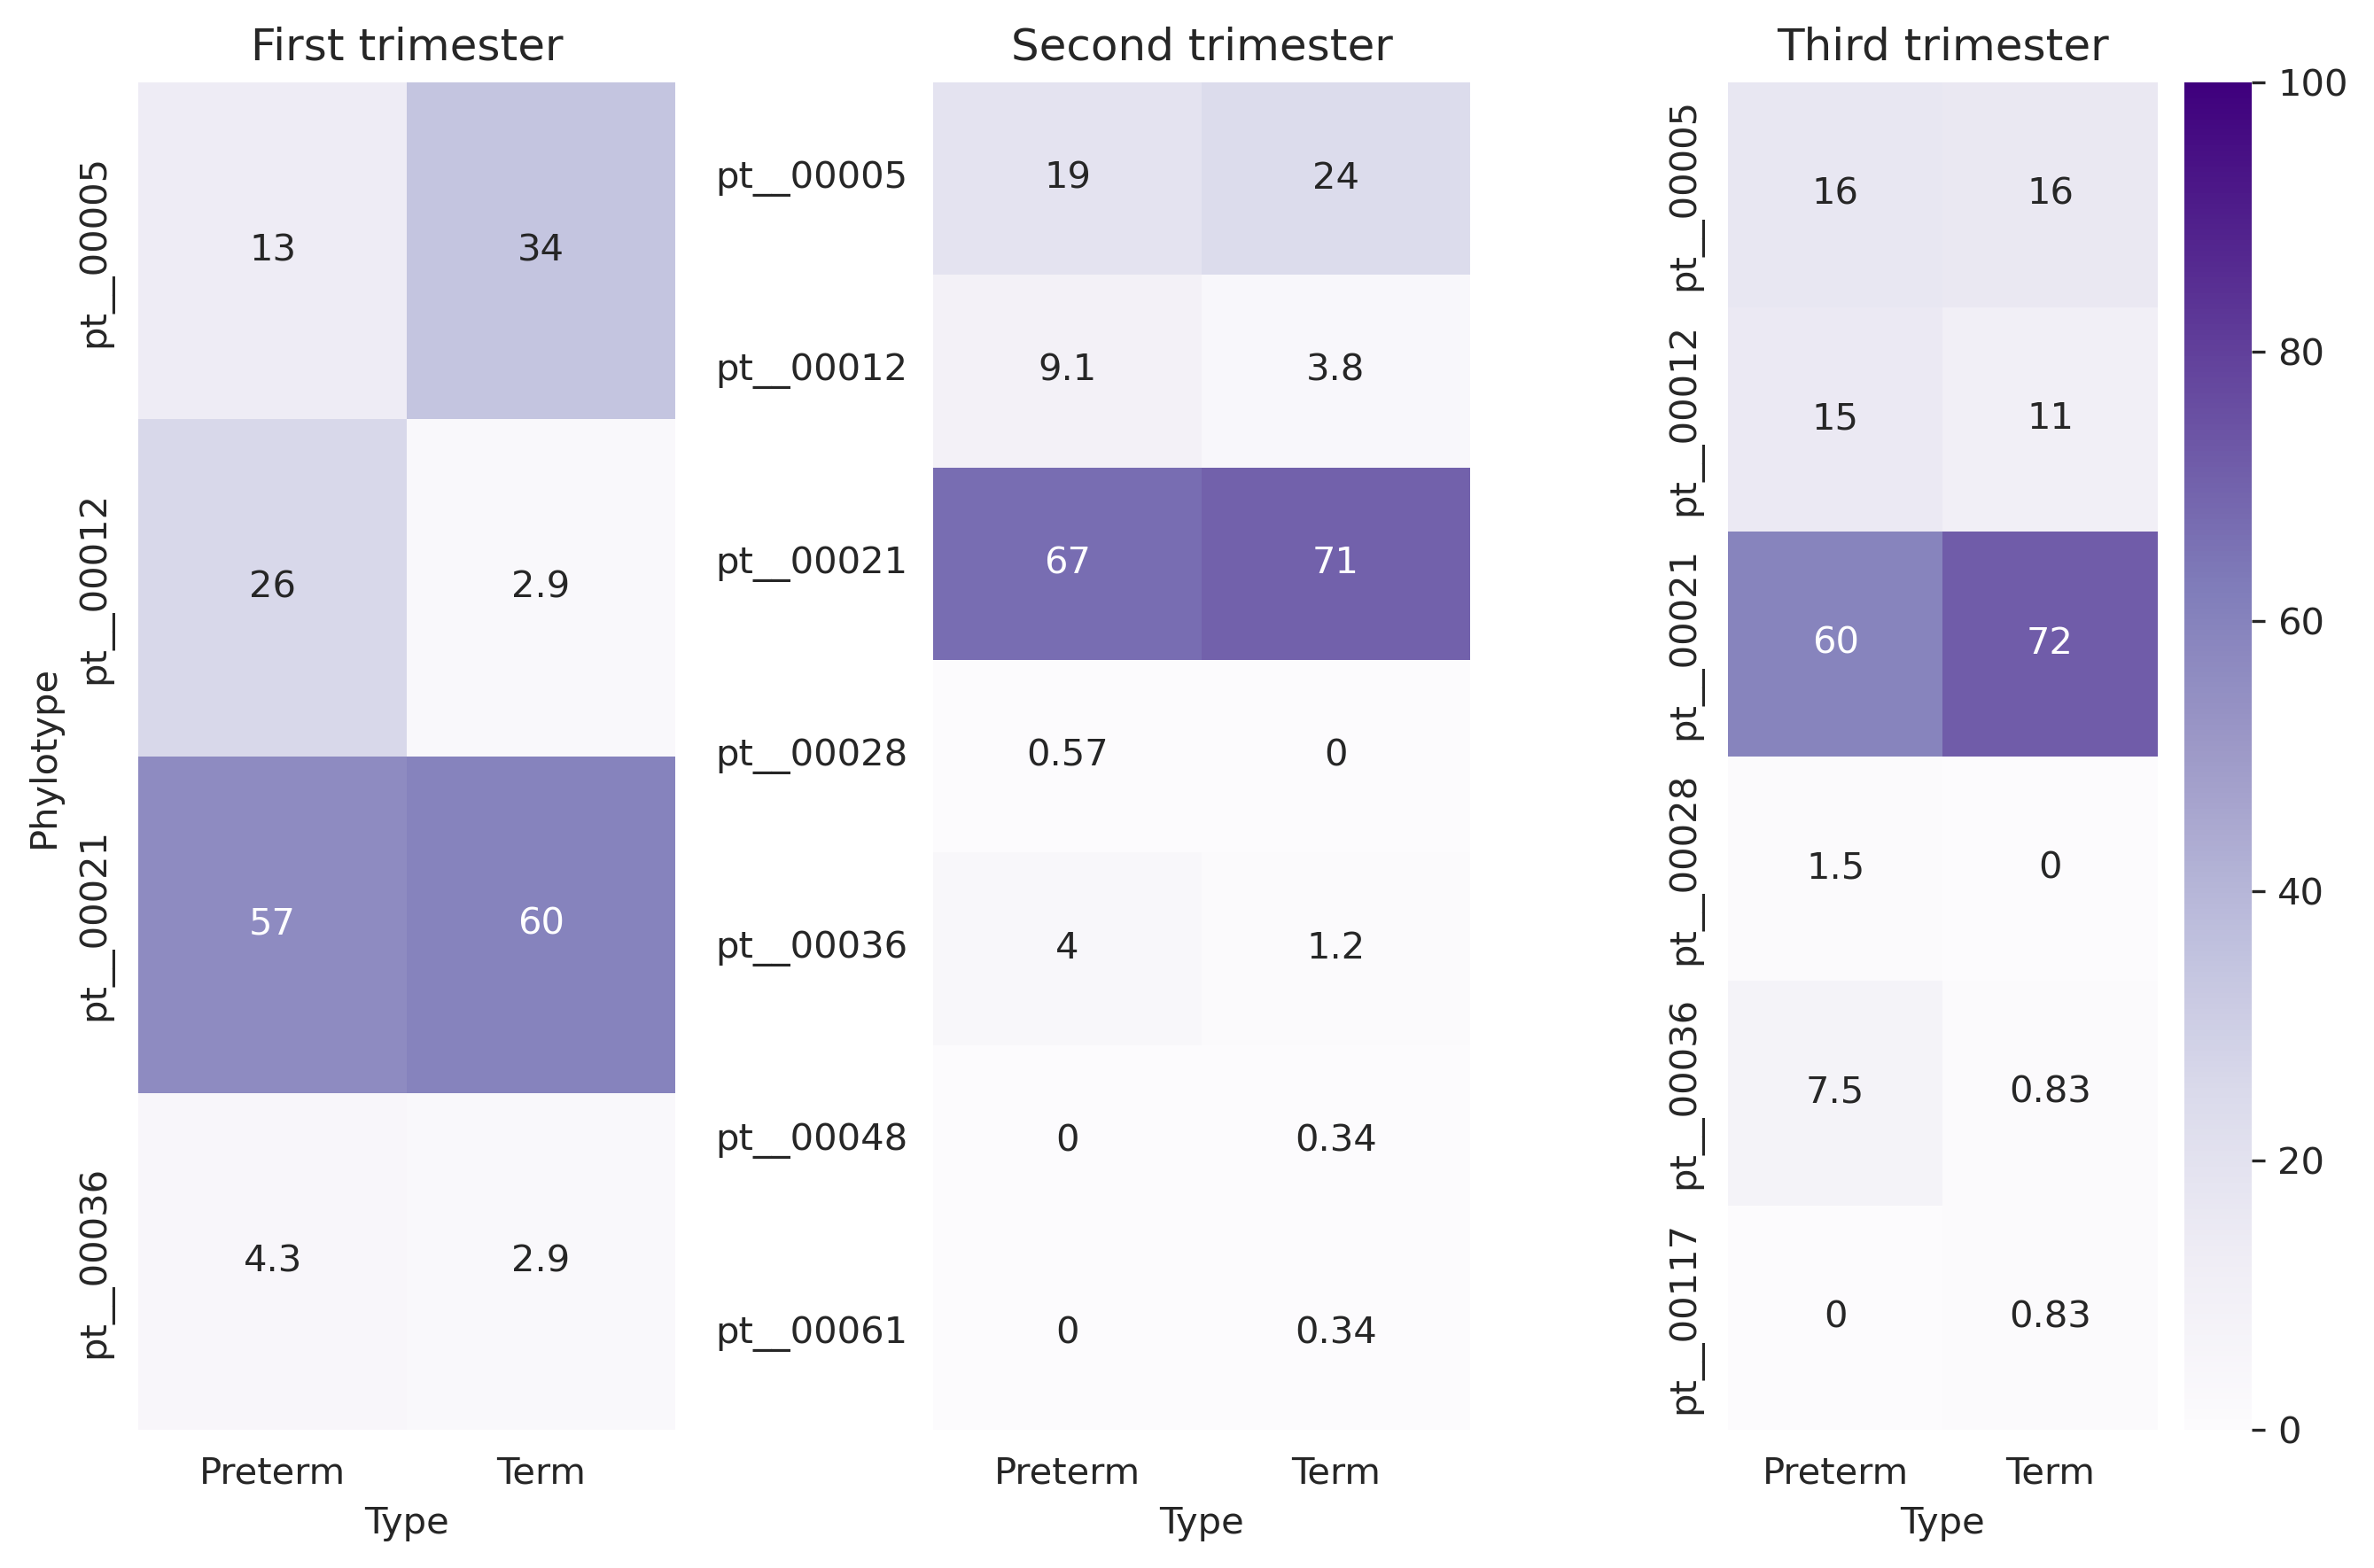

In [28]:
phy_trimester_list = []
for t in range(1,4):
    phy_tri = ptw_plot.query('trimester == @t')
    phy_trimester_list.append(pd.crosstab(phy_tri.Phylotype,
                                          phy_tri.Type
                                          , normalize='columns')*100)
    
trimesters = ['First','Second','Third']

fig, axes = plt.subplots(
    ncols=3,
    figsize=(9,6),
    sharey=False,
    dpi = 300
)
last=False

for i in range(0,3):
    if i == 2:
        last = True
    sns.heatmap(
        data=phy_trimester_list[i],
        cmap='Purples',
        vmin=0,
        vmax=100,
        ax=axes[i],
        annot = True,
        cbar=last
    )

    axes[i].set_xlabel("Type")
    axes[i].set_title(f'{trimesters[i]} trimester')
    if i != 0:
        axes[i].set_ylabel(None)

plt.tight_layout()
plt.show()

### Heatmap of samples vs phylotypes

In [74]:
to_heatmap = ptw.loc[results_ptb['phylotype'],:].T
to_heatmap
to_heatmpa = pd.concat([to_heatmap, metadata.loc[to_heatmap.index,:]], axis = 1)
to_heatmap.loc[ptw_plot.specimen,:]


,pt__00021,pt__00005,pt__00117,pt__00061,pt__00036,pt__00028,pt__00048,pt__00012
specimen,,,,,,,,
B00001-01,0.987768,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
B00005-01,0.999089,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
B00006-01,0.978590,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
B00008-01,0.966874,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
B00009-01,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
C00036-02,0.000000,0.0,0.0,0.0,0.544832,0.000000,0.000000,0.000000
C00109-01,0.000220,0.0,0.0,0.0,0.563000,0.000000,0.007638,0.023697
G00040-01,0.000086,0.0,0.0,0.0,0.000422,0.000376,0.000000,0.566852


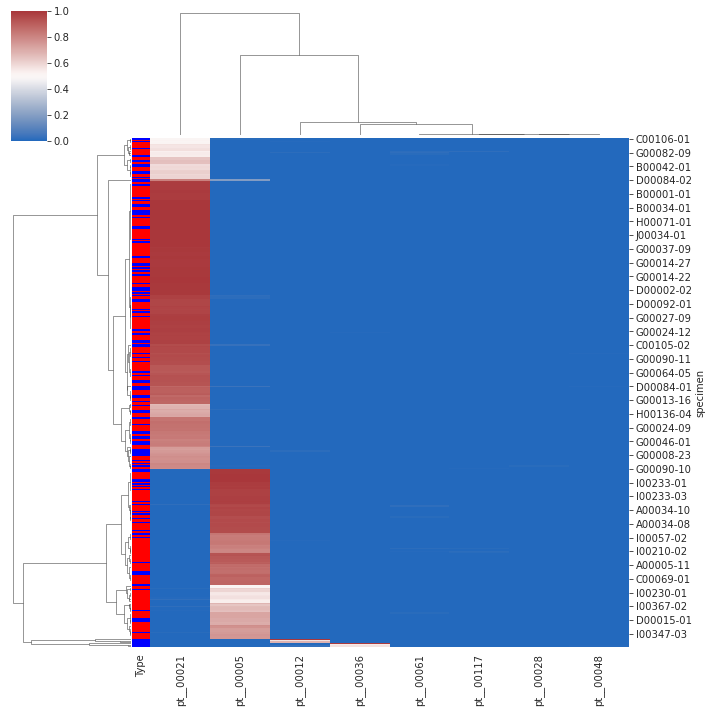

In [75]:
trimester = dict(zip(metadata.trimester.unique(), "rbg"))
types = dict(zip(metadata.Type.unique(), "rbg"))
row_colors = metadata.Type.map(types)
row_colors
sns.clustermap(to_heatmap.loc[ptw_plot.specimen,:], row_colors=row_colors, cmap="vlag")
plt.show()

## Early preterm model

In [49]:
pt_models_ra_eptb_wmd = {}
for pt, pt_data in ptw.iterrows():
    if (pt_data > MIN_RA).sum() / len(pt_data) < MIN_PREV:
        continue
    # Implicit else prevalent enough phylotype...
    exog = sm.add_constant(
        pt_data.to_frame(pt)
    )
    exog_wmd = pd.merge(
        exog,
        md[[
            'specimen',
            'Race: American Indian or Alaska Native',
            'Race: Asian',
            'Race: Black or African American',
            'Race: Native Hawaiian or Other Pacific Islander',
            'Race: Unknown',
            'Race: White',
            'trimester'
        ]],
        left_index=True,
        right_on='specimen',
        how='left'
    )
    exog_wmd.drop('specimen', inplace=True, axis=1)
    exog_wmd.index = exog.index
    m = sm.MixedLM(
        exog=exog_wmd,
        endog=ept_endog,
        groups=group
    ).fit()

    # Implict else did not error

    pt_models_ra_eptb_wmd[pt] = m

In [50]:
pt_res_ra_eptb = pd.DataFrame([
    {
        'phylotype': pt,
        'coef': pt_m.params[pt],
        'bse': pt_m.bse[pt],
        'p': pt_m.pvalues[pt]
    }
    for pt, pt_m in pt_models_ra_eptb_wmd.items()
])
pt_res_ra_eptb['wald'] = pt_res_ra_eptb['coef'] / pt_res_ra_eptb['bse']
pt_res_ra_eptb['q'] = multipletests(
    pt_res_ra_eptb['p'],
    method='fdr_bh'
)[1]
pt_res_ra_eptb

,phylotype,coef,bse,p,wald,q
0,pt__00001,0.003823,0.014612,0.793611,0.261625,0.870768
1,pt__00002,0.023536,0.045281,0.603222,0.519773,0.794242
2,pt__00003,0.031511,0.087931,0.720069,0.358366,0.849037
3,pt__00004,-0.056197,0.028648,0.049806,-1.961623,0.234605
4,pt__00005,-0.041997,0.030258,0.165143,-1.387979,0.421546
...,...,...,...,...,...,...
74,pt__00117,-1.569527,1.263762,0.214256,-1.241949,0.483605
75,pt__00143,-2.485825,1.810656,0.169788,-1.372886,0.421546
76,pt__00225,0.637604,1.053007,0.544842,0.605508,0.752172
77,pt__00358,-0.041649,0.146900,0.776780,-0.283518,0.870768


In [51]:
pd.merge(
    pt_res_ra_eptb[
        pt_res_ra_eptb.q <= 0.1
    ].sort_values('wald'),
    pt_tax,
    left_on='phylotype',
    right_index=True,
    how='left'
)

,phylotype,coef,bse,p,wald,q,tax_name
20,pt__00021,-0.081253,0.021336,0.000140,-3.808337,0.003684,Lactobacillus crispatus
31,pt__00033,-0.489946,0.188499,0.009344,-2.599192,0.067109,Escherichia coli
7,pt__00008,0.430135,0.147142,0.003464,2.923270,0.027364,Prevotella timonensis
44,pt__00048,2.596444,0.877177,0.003076,2.960000,0.027004,Mobiluncus curtisii
54,pt__00060,0.669148,0.218917,0.002238,3.056622,0.022105,Prevotella corporis
70,pt__00091,0.822311,0.266905,0.002064,3.080911,0.022105,Prevotella buccalis
42,pt__00045,0.505201,0.160945,0.001696,3.138957,0.022105,Streptococcus anginosus
18,pt__00019,0.450420,0.127007,0.000391,3.546418,0.006170,Prevotella bivia
49,pt__00055,2.407763,0.663835,0.000287,3.627049,0.005662,Peptostreptococcus anaerobius
60,pt__00069,4.131872,1.002668,0.000038,4.120876,0.001491,Anaerococcus vaginalis
